## 임베딩 내 편향성 알아보기 
여러 장르의 영화에 대해 예술, 일반영화 (target)의 편향성을 측정해 보고 시각화 해보기

### 평가기준
평가문항|상세기준
:---:|:---:
1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다. | 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.| 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

### Step 1.  형태소 분석기를 이용 품사가 명사인 경우 해당 단어를 추출하기 

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(5):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.


In [2]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

### Step 2. 추출결과로 임베딩 모델 만들기 
tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성. 

In [3]:
from gensim.models import Word2Vec

# Gensim 4.0 기준
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[('작품', 0.8746242523193359),
 ('다큐멘터리', 0.8359087109565735),
 ('드라마', 0.8211148977279663),
 ('영화로', 0.7839528918266296),
 ('형식', 0.7819488644599915),
 ('코미디', 0.7722441554069519),
 ('소재', 0.767646849155426),
 ('감동', 0.7628033757209778),
 ('주제', 0.7522667050361633),
 ('실화', 0.7426629066467285)]

### Step 3. Target, attribute 단어 세트 만들기 
WEAT score를 구할때 단어세트를 만들어 주어야 한다. TF-IDF를 사용해서 단어 셋을 만들때 어느정도는 대표 단어를 잘 선정할 수 있지만 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미친다. 

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠습니다. 즉 특정 장르의 영화는 예술영화적 성격이 강하고, 어떤 장르는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것이다.

In [4]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [5]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [13]:
art_txt = 'synopsis_art.txt'
art = read_token(art_txt)

gen_txt = 'synopsis_gen.txt'
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [14]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])
print(X.shape)

(2, 41082)


In [16]:
m1 = X[0].tocoo() # art를 TF-IDF로 표현한 sparse matrix를 가져온다. 
m2 = X[1].tocoo() # gen을 TF-IDF로 표현한 sparse matrix를 가져온다. 

w1 = [[i,j] for i,j in zip(m1.col, m1.data)]
w2 = [[i,j] for i,j in zip(m2.col, m2.data)]

w1.sort(key=lambda x:x[1], reverse=True) # art를 구성하는 단어들을 TF-IDF 높은순으로 정렬
w2.sort(key=lambda x:x[1], reverse=True)

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=',')
    
print('\n')

print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀,자신,시작,위해,사랑,사람,영화,친구,남자,가족,이야기,마을,사건,마음,세상,아버지,아이,엄마,모든,여자,대한,서로,과연,다시,시간,아들,소녀,아내,다른,사이,영화제,세계,사실,하나,점점,남편,감독,여행,인생,발견,모두,순간,우리,가장,마지막,생활,아빠,모습,통해,죽음,기억,비밀,학교,음악,한편,소년,생각,도시,명의,사고,결혼,전쟁,때문,위기,이제,최고,이자,과거,일상,경찰,상황,간다,미국,결심,운명,현실,관계,지금,단편,여인,하루,이름,이후,준비,인간,감정,만난,국제,처음,충격,살인,누구,동안,존재,그린,어머니,연인,계속,동생,작품,

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [17]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [18]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [19]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [20]:
genre=[]
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [21]:
len(genre)

21

In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [23]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

### Step 4. WEAT 
Word Embedding Association Test (WEAT)는 임베딩 모델의 편향을 측정하는 방식 중 하나로, 2016년에 Aylin Caliskan이 제안했다. WEAT에는 target 과 attribute이 있다. 예를들어, science를 대표하는 target 단어세트 X가 있고, art를 대표하는 단어세트 Y가 있다고 해보자. 그리고 male을 나타내는 단어세트 A와, female을 나타내는 단어세트 B가 있다고 해보자. 편향성이 없다면 X에 속한 단어들과 A, B에 속한 단어들과의 거리가 별 차이가 없어야 한다. 만약에 차이가 있다면, 즉, 값이 크다면 두 개념축 사이의 평향성이 크게 나타나는것으로 해석될 수 있다. 

word embedding(벡터)간의 유사도를 측정함으로 단어를 분류하거나, 편향성을 확인할 수 있다. WEAT score는 다음과 같이 정의한다. 
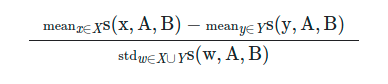

WEAT score 정의에 있는 s(w, A, B)를 먼저 이해해 보자. target에 있는 단어 w가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정. 절대값이 클수록 w는 A-B 개념축에 대해 편향성을 갖고 있다. 
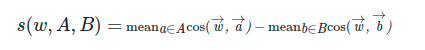
attribute A or B와 어떤 유사도를 갖는지 확인하기 위한 식
cosine similarity는 -1과 1사이의 값을 갖으며 두 벡터의 방향이 얼마나 유사한지를 나타내게 된다. 
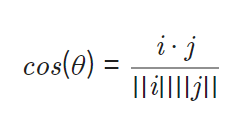
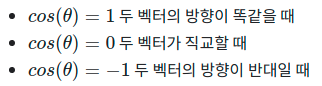
WEAT score의 분자는 편향성의 값을 나타냅니다.
편향성의 값은 -2에서 2 사이의 값을 갖습니다.
이 값을 정규화해주는 것으로 최종 WEAT score를 계산할 수 있다.


In [24]:
# 구현결과를 담을 21x21 matrix
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [25]:
matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [33]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [34]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b


def weat_score(Y, Z, A, B):
    
    s_Y = s(Y, A, B) 
    s_Z = s(Z, A, B) 

    mean_Y = np.mean(s_Y)
    mean_Z = np.mean(s_Z)
    
    std_dev = np.std(np.concatenate([s_Y, s_Z], axis=0))
    
    return  (mean_Y-mean_Z)/std_dev

In [35]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        Y = np.array([model.wv[word] for word in attributes[i]])
        Z = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(Y, Z, A, B)

In [36]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])


SF 멜로로맨스 -1.361353
공포(호러) 다큐멘터리 1.1808109
기타 멜로로맨스 -1.1882861
다큐멘터리 멜로로맨스 -1.5045484
다큐멘터리 미스터리 -1.3089887
다큐멘터리 성인물(에로) -1.2673699
다큐멘터리 스릴러 -1.1790279
멜로로맨스 범죄 1.2287117
멜로로맨스 서부극(웨스턴) 1.2098594
멜로로맨스 애니메이션 1.1801354
멜로로맨스 전쟁 1.4528853
미스터리 전쟁 1.1386777


### 결과 해석
* 다큐멘터리가 Y로 들어가 있는 weat score 들이 마이너스 값으로 나왔다. 이것은 다음을 의미한다. 
    * 마이너스 값이 나왔다는 것은 사람의 편향과 반대인 경우를 의미한다고 한다. 
    * 다큐멘터리 장르의 s(Y, A, B) 값이 작다. 이것은 곧, Y와 B의 코사인값이 Y와 A의 코사인 값보다 크다. B는 일반영화의 축이므로 편향이 크다고 볼 수 있다. 다큐멘터리가 예술영화에 가깝다는 면에서 맞는 분석인것 같다. 
* 멜로로맨스가 Y로 들어가 있는 weat score들이 1보다 큰 플러스 값으로 나왔다. 이것은 다음을 의미한다. 
    * 1보다 큰 플러스 값은 사람의 편향과 일치하는 것을 의미한다. 
    * 멜로로맨스 장르의 s(Y, A, B) 값이 크다. 이것은 곧, Y와 A의 코사인값이 B보다 크다는 것을 의미한다. A는 예술영화이므로, 멜로로맨스는 예술영화와 편향이 크다고 해석할 수 있다. 

<AxesSubplot:>

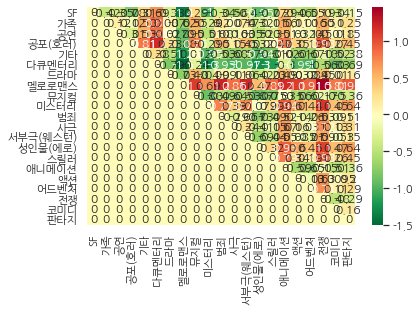

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')
# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax